In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('cleaned_data.csv')
df = df.drop(df.columns[[0]], axis=1)
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,1
1,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,0
2,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,0
3,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,0
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,Steady,No,No,No,No,No,No,Yes,1


In [3]:
'Number of patients in dataset is {:,}'.format(df['patient_nbr'].nunique())

'Number of patients in dataset is 68,630'

In [4]:
'Number of records in dataset is {:,}'.format(len(df))

'Number of records in dataset is 98,053'

## Pairwise Scatter Plots

In [5]:
import seaborn as sns
#sns.pairplot(df);

## HbAIc

In [10]:
# Using A1Cresult as signaling whether an HbA1c test was performed
df['A1Cresult'].value_counts()

None    81860
>8       7631
Norm     4854
>7       3708
Name: A1Cresult, dtype: int64

In [11]:
# Using 'change' as signaling whether diabetes med changed
df['change'].value_counts()

No    52774
Ch    45279
Name: change, dtype: int64

In [12]:
df_egroups = df[['A1Cresult', 'change']]

In [13]:
h =df_egroups.groupby('A1Cresult').count()
h

,change
A1Cresult,
>7,3708
>8,7631
None,81860
Norm,4854


In [14]:
pd.crosstab(df_egroups.A1Cresult, df_egroups.change)

change,Ch,No
A1Cresult,,
>7,1885,1823
>8,5052,2579
None,36186,45674
Norm,2156,2698


In [15]:
# view distribution of med change status across different a1c results. 
pd.crosstab(df_egroups.A1Cresult, df_egroups.change).apply(lambda r: r/r.sum(), axis=0)
## majority of those with a change had no testing, but most patients didn't get testing

change,Ch,No
A1Cresult,,
>7,0.041631,0.034544
>8,0.111575,0.048869
None,0.799178,0.865464
Norm,0.047616,0.051124


In [16]:
# view distribution of med change stratified by a1c results
pd.crosstab(df_egroups.A1Cresult, df_egroups.change).apply(lambda r: r/r.sum(), axis=1)
## a larger share of patients with high a1c results had med changes than those with non-elevated a1c results
# plt.savefig('HbA1cMeds.jpg')

change,Ch,No
A1Cresult,,
>7,0.508360,0.491640
>8,0.662036,0.337964
None,0.442047,0.557953
Norm,0.444170,0.555830


In [17]:
df2 = df.copy()

In [18]:
def label_encounter (row):
    if row['A1Cresult'] == 'None': return 'None'
    if row['A1Cresult'] == 'Norm': return 'Normal'
    if row['A1Cresult'] == '>8' and row['change']=='No': return 'High Medical No Change'
    if row['A1Cresult'] == '>8' and row['change']=='Ch': return 'High Medical Change'
    return 'Other'

In [19]:
df2['encounter_group'] =df2.apply (lambda row: label_encounter (row),axis=1)

In [20]:
# seeing who the "Other" cases are...the paper grouping didn't consider when >7, but less than 8.
df2[['A1Cresult','change']][df2.encounter_group == 'Other'].sample(2)

,A1Cresult,change
4722,>7,Ch
50834,>7,Ch


In [21]:
# another view of counts by encounter groups
df2['encounter_group'].value_counts()

None                      81860
High Medical Change        5052
Normal                     4854
Other                      3708
High Medical No Change     2579
Name: encounter_group, dtype: int64

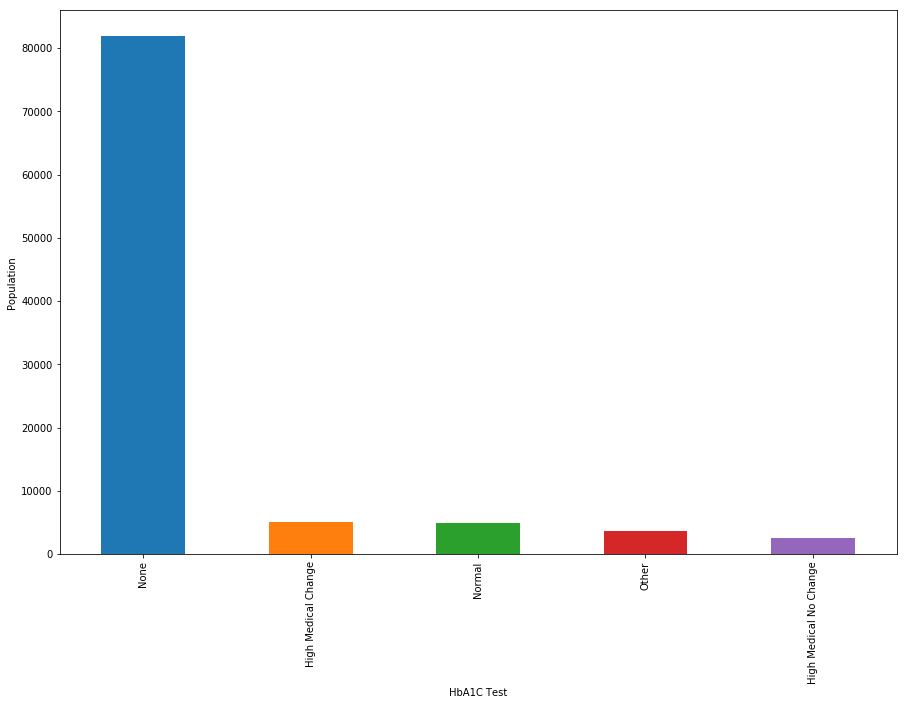

In [22]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,10))
df3 = df2['encounter_group'].value_counts()
df3.plot(kind = 'bar')
plt.xlabel('HbA1C Test')
plt.ylabel('Population')
plt.savefig('HbA1cResults.jpg')

### Label the Diagnosis

In [23]:
def label_diagnosis (i):
    i= i.strip("V").strip("E")
#     i = float(i)
    if i in list(range(390,495)) or i=='785': return 'Circulatory'
    elif i in list(range(460,519)) or i=='786': return 'Respiratory'
    elif i in list(range(520,579)) or i=='787': return 'Digestive'
    elif float(i)>=250 and float(i)<251: return 'Diabetes'
    elif i in list(range(800,999)): return 'Injury'
    elif i in list(range(710,739)): return 'Musculoskeletal'
    elif i in list(range(580,629)) or i=='788': return 'Genitourinary'
    elif i in list(range(140,239)): return 'Neoplasms'
    else: return 'Other'

In [24]:
df2['diag_1'] =df2['diag_1'].apply(label_diagnosis)

In [25]:
print(df2['diag_1'].unique())

['Other' 'Diabetes' 'Respiratory' 'Digestive' 'Genitourinary'
 'Circulatory']


## HbA1c Effects on Medication Number

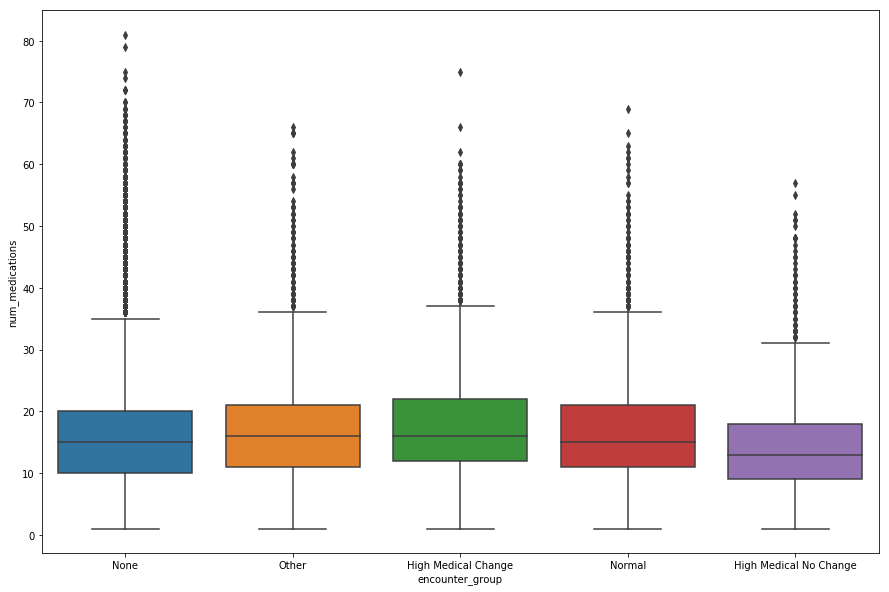

In [26]:
import seaborn as sns

# For all patients
plt.figure(figsize=(15,10))
sns.boxplot(x=df2['encounter_group'],y=df2['num_medications'])

Text(0, 0.5, 'Number of Medications')

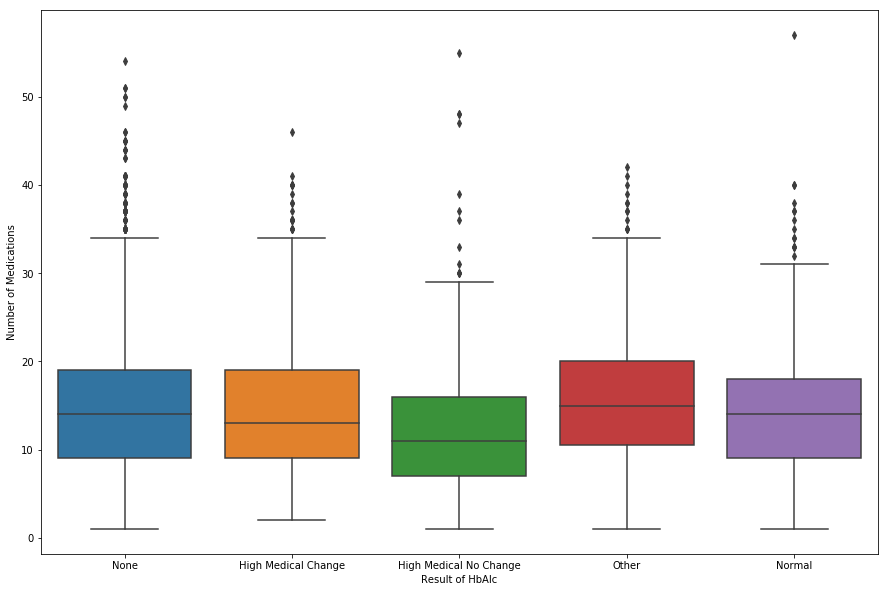

In [27]:
## For patients whose primary diagnosis was Diabetes
plt.figure(figsize=(15,10))
diabetes = df2[df2['diag_1']=='Diabetes']
sns.boxplot(x=diabetes['encounter_group'],y=diabetes['num_medications'])
plt.xlabel('Result of HbAIc')
plt.ylabel('Number of Medications')

## Hospital Readmission Ratios vs. HbA1c Results

In [28]:
## For patients whose primary diagnosis was Diabetes
plt.figure(figsize=(15,10))
d2 = pd.DataFrame(diabetes.groupby(['encounter_group'])['readmitted'].sum())
d2.columns = ['num_readmitted']
d2.reset_index(inplace=True)
print(d2)

          encounter_group  num_readmitted
0     High Medical Change             511
1  High Medical No Change             240
2                    None            3091
3                  Normal             214
4                   Other             145


<Figure size 1080x720 with 0 Axes>

In [29]:
d3 = pd.DataFrame(diabetes['encounter_group'].value_counts())
d3.reset_index(inplace=True)
d3.columns = ['encounter_group','num_group']
print(d3)

          encounter_group  num_group
0                    None       5561
1     High Medical Change       1168
2  High Medical No Change        509
3                  Normal        444
4                   Other        283


          encounter_group  num_readmitted  num_group  readmission_ratio
0     High Medical Change             511       1168           0.437500
1  High Medical No Change             240        509           0.471513
2                    None            3091       5561           0.555835
3                  Normal             214        444           0.481982
4                   Other             145        283           0.512367


Text(0, 0.5, 'Readmission Ratio')

<Figure size 1080x720 with 0 Axes>

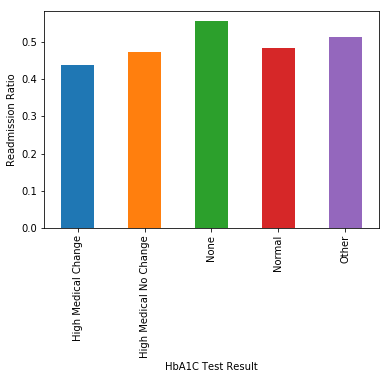

In [30]:
d4 = d2.merge(d3, on='encounter_group')
d4['readmission_ratio']= d4['num_readmitted'] / d4['num_group']

print(d4)
plt.figure(figsize=(15,10))
d4.plot(kind='bar', x='encounter_group', y='readmission_ratio',legend=False)
plt.xlabel('HbA1C Test Result')
plt.ylabel('Readmission Ratio')

## Summary

* Diabetic patients are primarily diagnosed as serval diseases. Most of the diagnoses are performed without HbA1c test. However, HbA1c test is a very improtant parameter for efficient treatment of diabetic patients.  

* Using the mdication numbers of normal HbA1c result as baseline, the high H1bAc test with medication change results in an increase medication number. However, that without medication change reduces medication number.

* The relationship between the readmission ratio and the HbA1c measurement signicantly depends on the primary diagnosis. Our analyses indicate whether medication change of high HbA1c result is effective for different primary diagnosis.  